# 生成对抗网络简介


参考资料：

- [A Friendly Introduction to Generative Adversarial Networks (GANs)](https://www.youtube.com/watch?v=8L11aMN5KY8)
- [Generative Adversarial Networks](https://developers.google.com/machine-learning/gan)
- [通俗理解生成对抗网络GAN](https://zhuanlan.zhihu.com/p/33752313)
- [eriklindernoren/PyTorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN)
- [Understanding Generative Adversarial Networks (GANs)](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)
- [A Beginner's Guide to Generative Adversarial Networks (GANs)](https://wiki.pathmind.com/generative-adversarial-network-gan)
- [GANs from Scratch 1: A deep introduction. With code in PyTorch and TensorFlow](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f)

GANs是机器学习的一项创新性进展，GANs是生成式的模型：它们能创建新的类似于训练数据的数据实例。比如GANs能创建看起来像人脸的图像，即使这些图像不属于任何人。

GAN 通过将 学习产生目标输出的 生成器 与学习 区分真实数据和生成器输出 的鉴别器 配对 来实现高水平的真实性。生成器试图欺骗鉴别器，鉴别器试图避免被欺骗。

关于GANs，我们需要知道的基本内容主要有：

- 了解生成模型。
- 确定 GAN 可以解决的问题。
- 了解生成器和鉴别器在 GAN 系统中的作用。
- 了解常见 GAN 损失函数的优缺点。
- 确定 GAN 训练常见问题的可能解决方案。
- 简单实现GAN（这里以PyTorch为例）

## 从生成随机变量开始

首先，看看生成随机变量的过程，特别是允许从简单的均匀随机变量生成复杂随机变量的逆变换方法。尽管所有这些似乎与本文的主题 GAN 相距甚远，但我们将在下一节中看到与生成模型存在的深层联系。

### 可以伪随机生成均匀随机变量

计算机基本上是确定性的。因此，从理论上讲，生成真正随机的数字是不可能的（即使是“什么是随机性？”这个问题就很困难）。但是，可以定义生成数字序列的算法，其属性非常接近理论随机数序列的属性。特别地，计算机能够使用伪随机数生成器生成一个数字序列，该序列近似遵循 0 和 1 之间的均匀随机分布。均匀分布是一种非常简单的情况，可以在此基础上使用不同的方式构建更复杂的随机变量。

### 表示为运算或过程结果的随机变量

存在旨在生成更复杂的随机变量的不同技术。其中，我们可以找到例如逆变换方法、拒绝采样、Metropolis-Hasting 算法等（更多介绍可以看看[这里](https://github.com/OuyangWenyu/hydro-bayes-mcmc)）。所有这些方法都依赖于不同的数学技巧，这些技巧主要包括将我们想要生成的随机变量表示为运算（通过更简单的随机变量）或过程的结果。

[拒绝抽样将](https://en.wikipedia.org/wiki/Rejection_sampling)随机变量表示为一个过程的结果，该过程不是从复杂分布而是从众所周知的简单分布中抽样，并根据某些条件接受或拒绝抽样值。重复这个过程直到采样值被接受，我们可以证明在正确的接受条件下，有效采样的值将遵循正确的分布。

在 [Metropolis-Hasting 算法](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)中，想法是找到一个马尔可夫链 (MC)，使得该 MC 的平稳分布对应于我们想要从中采样随机变量的分布。一旦找到这个 MC，我们就可以在这个 MC 上模拟足够长的轨迹，以认为我们已经达到稳定状态，然后我们通过这种方式获得的最后的值可以被认为是从感兴趣的分布中提取的。

这里不会进一步讨论拒绝抽样和 Metropolis-Hasting 的细节，因为这些方法不会引导我们了解 GAN 背后的概念。但是，让我们更多地关注逆变换方法。

### 逆变换法

逆变换方法的思想只是来简单地表示我们的“复杂性”——在本文中，“复杂性”应该始终理解为“不简单”的意义，而不是数学意义上的——随机变量作为应用于我们知道如何生成的均匀随机变量的函数的结果。

在接下来一维例子中考虑。令 X 是我们想要从中采样的复杂随机变量，而 U 是我们知道如何从中采样的 [0,1] 范围内的均匀随机变量。注意，随机变量完全由其累积分布函数 ([CDF](https://en.wikipedia.org/wiki/Cumulative_distribution_function)) 定义。随机变量的 CDF 是从随机变量的定义域到区间 [0,1] 的函数，并在一维中定义，使得：

$$CDF_X (x)=P(X\leq x) \ \ \ \ \ \ \in [0,1]$$

在均匀随机变量 U 的特殊情况下，我们有：

$$CDF_U (u)=P(U\leq u) = u \ \ \ \ \ \ {\forall}u \in [0,1]$$

为简单起见，我们在这里假设函数 $CDF_X$ 是可逆的，它的逆表示为

$$CDF_X^{-1}$$

（通过使用函数的广义逆，该方法可以很容易地扩展到不可逆的情况，但这实际上不是我们在这里要关注的重点）。那么如果我们定义

$$Y=CDF_X^{-1}(U)$$

我们有

$$CDF_Y(y)=P(Y\leq y)=P(CDF_X^{-1}(U)\leq y)=P(U\leq CDF_X(y))=CDF_X(y)$$


正如我们所见，Y 和 X 具有相同的 CDF，然后定义了相同的随机变量。因此，通过如上所述定义 Y（作为均匀随机变量的函数），我们已经设法定义了一个具有目标分布的随机变量。
总而言之，逆变换方法是一种通过使均匀随机变量经过精心设计的“变换函数”（逆 CDF）来生成遵循给定分布的随机变量的方法。事实上，这种“逆变换方法”的概念可以扩展为“变换方法”的概念，更一般地说，它包括**生成随机变量作为一些更简单的随机变量的函数**（不一定是均匀分布，然后变换函数也不一定再是逆 CDF）。从概念上讲，“变换函数”的目的是对初始概率分布进行变形/重塑：变换函数从初始分布与目标分布相比过高的位置，并将其放在过低的位置。

![](img/1_Xoz06MKgbw7CZ8aNbMCt6A.jpeg)

## 生成式模型

### 我们尝试生成非常复杂的随机变量......

假设我们对生成大小为 n x n 像素的狗的黑白方形图像感兴趣。我们可以将每个数据重塑为 N=nxn 维向量（通过将列堆叠在彼此之上），这样狗的图像就可以用向量表示。然而，这并不意味着所有的向量变回正方形都能代表一只狗！所以，我们可以说，能有效地给出看起来像狗的东西的 N 维向量是 根据整个 N 维向量空间上的非常特定的概率分布 来 分布的（该空间的某些点很可能代表狗，而其他一些点则极不可能代表狗）。本着同样的精神，在这个 N 维向量空间上，存在猫、鸟等图像的概率分布。

那么，生成新的狗图像的问题就等价于在N维向量空间上生成符合“狗概率分布”的新向量的问题。因此，我们实际上面临着生成关于特定概率分布的随机变量的问题。

在这一点上，我们可以提两件重要的事情。首先我们提到的“狗概率分布”是一个非常大的空间上的非常复杂的分布。其次，即使我们可以假设存在这种潜在分布（实际上存在看起来像狗的图像和其他看起来不像的图像），我们显然不知道如何明确表达这种分布。前两点使得从这个分布生成随机变量的过程变得非常困难。下面就让我们试着解决这两个问题。

### ......所以让我们使用神经网络作为函数的变换方法！

在尝试生成新的狗图像时，我们的第一个问题是 N 维向量空间上的“狗概率分布”非常复杂，我们不知道如何直接生成复杂的随机变量。然而，由于我们很清楚如何生成 N 个不相关的均匀随机变量，我们可以使用变换方法。为此，我们需要将 N 维随机变量表示为一个非常复杂的函数应用于简单的 N 维随机变量的结果！

在这里，我们可以强调一个事实，即找到变换函数并不像我们在描述逆变换方法时所做的那样，仅仅取累积分布函数的逆（我们显然不知道）那么简单。转换函数无法明确表达，因此我们必须从数据中学习它。

在大多数情况下，非常复杂的函数自然就意味着要用神经网络建模了。想法是通过神经网络对变换函数进行建模，该神经网络将一个简单的 N 维均匀随机变量作为输入，并返回另一个 N 维随机变量作为输出，该变量在训练后应遵循正确的“狗概率分布” .一旦设计了网络的架构，我们仍然需要对其进行训练。

![](img/1_CkMMefLPqcEKPuuPLZY2_A.png)

后面将讨论训练这些生成网络的方法，包括 GAN 背后的对抗训练思想！

### 生成式模型的一点稍正式的概念

接下来补充一点关于生成式模型的基本概念。

生成式模型中的“生成”描述了一类与判别模型形成对比的统计模型。

- 生成模型可以生成新的数据实例。
- 判别模型区分不同类型的数据实例。

生成模型可以生成看起来像真实动物的新动物照片，而判别模型可以区分狗和猫。 GAN 是一种生成模型。

更正式地，给定一组数据实例 X 和一组标签 Y：

- 生成模型获取联合概率 p(X, Y)，如果没有标签，则仅得到 p(X)。
- 判别模型获取条件概率 p(Y|X)。

生成模型包括数据本身的分布，并告诉我们给定的例子的可能性有多大。例如，预测序列中下一个单词的模型通常是生成模型（通常比 GAN 简单得多），因为它们可以为单词序列分配概率。

判别模型忽略给定实例是否可能的问题，而只是告诉标签应用于实例的可能性有多大。

请注意，这是一个非常简单的定义。生成模型有很多种，GAN 只是其中一种。

建模概率：

两种模型都不必返回表示概率的数字。可以通过模仿该分布来对数据分布进行建模。

例如，像决策树这样的判别分类器可以在不为一个标记分配概率的情况下标记一个实例。这样的分类器仍然是一个概率模型，因为所有预测出的标签的分布将一起模拟数据中标签的真实分布。

类似地，生成模型可以通过生成令人信服的“假”数据来对分布进行建模，这些数据看起来像是从该分布中提取的。

生成模型很难：

生成模型和类似的判别模型相比，是更困难处理的。生成模型必须建模更多。

图像的生成模型可能会捕获诸如“看起来像船的东西可能会出现在看起来像水的东西附近”和“眼睛不太可能出现在额头上”之类的相关性。这些是非常复杂的分布。

相比之下，判别模型可能仅通过寻找一些明显的模式来了解“帆船”或“非帆船”之间的区别。它可能会忽略生成模型必须正确处理的许多相关性。

判别模型试图在数据空间中划定边界，而生成模型则试图对数据在整个空间中的放置方式进行建模。例如，下图显示了手写数字的判别模型和生成模型：

![](img/generative_v_discriminative.png)

判别模型试图通过在数据空间中画一条线来区分手写的 0 和 1。如果它得到正确的划分界限，它就可以区分 0 和 1，而不必精确地建模实例在行两侧的数据空间中的放置位置。

相比之下，生成模型试图通过生成接近数据空间中真实对应物的数字来产生令人信服的 1 和 0，所以它必须对整个数据空间的分布进行建模。

GAN 提供了一种有效的方法来训练如此丰富的模型以模拟真实的分布。稍后会介绍。

## 生成匹配网络

本节的题目 Generative Matching Networks “生成匹配网络”不是标准名称。不过可以在文献中找到，例如“生成矩匹配网络”或“生成特征匹配网络”。这里只是想对在下面描述的内容使用一个稍微更通用的名称。

### 训练生成模型

到目前为止，我们已经说明了生成新狗图像的问题可以改写为在遵循“狗概率分布”的 N 维向量空间中生成随机向量的问题，并且我们建议使用变换方法———使用神经网络对变换函数进行建模。

现在，我们仍然需要训练（优化）网络来表达正确的变换函数。为此，我们可以建议两种不同的训练方法：直接训练方法和间接训练方法。直接训练方法包括比较真实和生成的概率分布，并通过网络反向传播误差。这就是 生成匹配网络（GMN）的思路。对于间接训练方法，我们不直接比较真实分布和生成分布。相反，我们通过让这两个分布经过一个选择的下游任务来训练生成网络，这样生成网络相对于下游任务的优化过程将强制生成分布接近真实分布。后一个想法是就是后面将介绍的生成对抗网络 (GAN) 背后的想法。但是现在，让我们从直接方法和 GMN 开始。

### 比较基于样本的两个概率分布

如前所述，GMN 的思想是通过直接将生成的分布与真实分布进行比较来训练生成网络。然而，我们**不知道如何明确表达真正的“狗概率分布”**，我们也可以说生成的分布太复杂而无法明确表达。因此，**基于显式表达式的比较是不可能的**。但是，如果我们有一种**基于样本比较概率分布的方法**，我们可以用它来训练网络。事实上，我们有一个真实数据的样本，我们可以在训练过程的每次迭代中生成一个生成数据的样本。

尽管理论上可以使用能够有效比较基于样本的两个分布的任何距离（或相似性度量），但我们特别提到最大平均差异（MMD）方法。 MMD 定义了可以基于这些分布的样本计算（估计）的两个概率分布之间的距离。这里简单描述下 MMD。原文作者提供了更多[参考](http://www.gatsby.ucl.ac.uk/~gretton/papers/testing_workshop.pdf)，其中包含有关它的更多详细信息。

### 分布匹配误差的反向传播

因此，一旦我们定义了一种基于样本比较两个分布的方法，我们就可以定义 GMN 中生成网络的训练过程。给定一个具有均匀概率分布的随机变量作为输入，我们希望生成输出的概率分布是“狗概率分布”。然后 GMN 的想法是通过重复以下步骤来优化网络：

- 生成一些均匀分布输入
- 使这些输入通过网络并收集生成的输出
- 比较真实的“狗概率分布”和基于可用样本生成的分布（例如计算真实狗图像样本和生成样本之间的 MMD 距离）
- 使用反向传播进行一步梯度下降以降低真实分布和生成分布之间的距离（例如 MMD）

如上所述，在执行这些步骤时，我们在网络上应用梯度下降，其损失函数是当前迭代中真实分布和生成分布之间的距离。

![](img/1_Pg-z4jKFyHtIMvcQWefLSQ.png)

## GAN基本概念

### “间接”训练法

上面介绍的“直接”方法在训练生成网络时直接将生成的分布与真实分布进行比较。 GAN 的绝妙想法在于，将这种直接比较替换为间接比较，该间接比较采用这两个分布的下游执行任务的形式。针对此任务完成生成网络的训练，以便它迫使生成的分布越来越接近真实分布。

GAN 的下游任务是区分真实样本和生成样本的任务。或者我们可以说“non-discrimination”任务，因为我们希望鉴别尽可能失败。因此，在 GAN 架构中，我们有一个鉴别器，它从真实数据和生成数据中获取样本，并尝试尽可能对它们进行分类，还有一个经过训练以尽可能欺骗鉴别器的生成器。让我们看一个简单的例子，为什么我们提到的直接和间接方法理论上应该导致相同的最佳生成器。


### 理想情况：完美的生成器和鉴别器

为了更好地理解为什么训练生成器来愚弄判别器会导致与直接训练生成器匹配目标分布的结果相同，让我们举一个简单的一维示例。我们暂时忘记了生成器和鉴别器是如何表示的，而是将它们视为抽象概念。此外，在不受任何类型（参数化）模型约束的意义上，两者都被认为是“完美的”（具有无限的能力）。

假设我们有一个真实的分布，例如一个一维高斯分布，并且我们想要一个从这个概率分布中采样的生成器。我们所谓的“直接”训练方法将包括迭代调整生成器（梯度下降迭代）以校正真实分布和生成分布之间的测量差异/误差。最后，假设优化过程完美，我们最终应该得到与真实分布完全匹配的生成分布。

![](img/1_3XAUCz6o2DZlGHVsovvRIQ.jpeg)

对于“间接”方法，我们还必须考虑鉴别器。我们现在假设这个鉴别器是一种预言机，它确切地知道真实分布和生成分布是什么，并且能够根据这些信息预测任何给定点的类别（“真实”或“生成”）。如果这两个分布相距甚远，则鉴别器将能够以高置信度轻松地对我们提供给它的大多数点进行分类。如果我们想欺骗鉴别器，我们必须使生成的分布接近真实的分布。当两个分布在所有点上都相等时，判别器将最难预测类别：在这种情况下，对于每个点，它是“真”或“生成”的概率相等，然后判别器就很难这种二分之一的条件下比一半一半随机猜做的更好了。

![](img/1_5PUywl6tcsHpQ1Co6P92lA.jpeg)

这种间接方法是否真的是一个好主意呢？实际上，它似乎更复杂，我们必须基于下游任务而不是直接基于分布来优化生成器；并且它需要一个鉴别器，我们在这里将其视为给定的预言机，但实际上，对它我们也是不知道的。对于第一点，基于样本直接比较两个概率分布的困难是能抵消间接方法明显更高的复杂性的。对于第二点，显然判别器是未知的，不过，它是可以学习的！

### 对抗性神经网络

现在让我们描述在 GAN 架构中采用生成器和鉴别器的具体形式。生成器是一个对变换函数进行建模的神经网络。它接受一个简单的随机变量作为输入，并且必须在训练后返回一个遵循目标分布的随机变量。由于它非常复杂且未知，我们决定用另一个神经网络对鉴别器进行建模。该神经网络对判别函数进行建模。它接受一个点（在我们的狗的例子中是一个 N 维向量）作为输入，并返回这个点是“真实”点的概率作为输出。

请注意，我们现在强加参数化模型来表达生成器和鉴别器（而不是上一小节中的理想化版本）这一事实，实际上对上面给出的理论论证/直觉没有太大影响：我们只是在一些参数化空间而不是理想的完整空间中工作，因此，我们在理想情况下应该达到的最佳点可以被参数化模型的精度能力视为“四舍五入”。

一旦定义好，两个网络就可以（同时）以相反的目标联合训练：

- 生成器的目标是愚弄判别器，因此训练生成神经网络以最大化最终分类误差（真实数据和生成数据之间）
- 判别器的目标是检测假生成的数据，因此训练判别神经网络以最小化最终分类错误

因此，在训练过程的每次迭代中，生成网络的权重都会更新以增加分类误差（生成器参数上的误差梯度上升），而判别网络的权重会更新以减少该误差（鉴别器参数上的误差梯度下降）。

![](img/1_t82vgL9KcDVpT4JqCb9Q4Q.png)

这些相反的目标和两个网络对抗性训练的隐含概念解释了“对抗性网络”的名称：两个网络都试图相互击败，并且这样做，它们都变得越来越好。它们之间的竞争使这两个网络在各自的目标方面“进步”。从博弈论的角度来看，我们可以将此设置视为一个极小极大的两人游戏，其中均衡状态对应于生成器从精确的目标分布中生成数据以及判别器预测“真实”或“生成”的情况。 ”它接收到的任何点的概率为 1/2。

所以，生成对抗网络（GAN）的两个部分：

- 生成器学习生成合理的数据。生成的实例成为鉴别器的负训练实例。
- 鉴别器学习区分生成器的假数据和真实数据。鉴别器惩罚生成器以产生难以置信的结果。

当训练开始时，生成器产生明显的假数据，判别器很快学会辨别它是假的：

![](img/bad_gan.svg)

随着训练的进行，生成器越来越接近于产生可以欺骗鉴别器的输出：

![](img/ok_gan.svg)

最后，如果生成器训练顺利，判别器在区分真假时会变得更糟。它开始将虚假数据归类为真实数据，其准确性降低。

![](img/good_gan.svg)

这是整个系统的图片：

![](img/gan_diagram.svg)

生成器和鉴别器都是神经网络。生成器输出直接连接到鉴别器输入。通过反向传播，鉴别器的分类提供了生成器用来更新其权重的信号。

将生成对抗网络与其他神经网络（例如自动编码器和变分自动编码器）进行简单比较可能有助于理解。

自编码器将输入数据编码为向量。它们创建原始数据的隐藏或压缩表示。它们在降维方面很有用；也就是说，作为隐藏表示的向量将原始数据压缩为较少数量的显着维度。自编码器可以与所谓的解码器配对，它允许您根据其隐藏表示重建输入数据，就像使用受限玻尔兹曼机一样。

![](img/autoencoder_schema.jpg)

变分自编码器是一种生成算法，它为输入数据的编码添加了额外的约束，即隐藏表示被归一化。变分自编码器既能像自编码器一样压缩数据，也能像 GAN 一样合成数据。然而，GAN 生成的数据非常精细，而 VAE 生成的图像往往更加模糊。

您可以将生成算法分为以下三种类型之一：

- 给定一个标签，他们预测相关的特征（朴素贝叶斯）
- 给定一个隐藏的表示，他们预测相关的特征（VAE，GAN）
- 给定一些特征，他们预测其余的（修复，插补）

接下来更详细地解释GAN的各个部分。

### 判/鉴别器

GAN 中的鉴别器只是一个分类器。它试图将真实数据与生成器创建的数据区分开来。它可以使用适合其分类数据类型的任何网络架构。

![](img/gan_diagram_discriminator.svg)

鉴别器训练数据：

判别器的训练数据有两个来源。

- 真实数据实例，如人物的真实照片。鉴别器在训练期间使用这些实例作为正例。
- 生成器创建的假数据实例。鉴别器在训练期间使用这些实例作为反例。

在上图中，两个“样本”框代表这两种输入鉴别器的数据源。在鉴别器训练期间，生成器不训练。它的权重保持不变，同时它为判别器生成示例进行训练。

训练鉴别器：

鉴别器连接到两个损失函数。在判别器训练期间，判别器忽略生成器的损失，只使用判别器损失。在生成器训练期间才会使用生成器损失，下一小节进一步说明。

在鉴别器训练期间：

1. 鉴别器对真实数据和来自生成器的假数据进行分类。
2. 鉴别器损失惩罚鉴别器将真实实例错误分类为假或假实例错误分为为真的情况。
3. 鉴别器 通过 通过鉴别器网络的鉴别器损失的反向传播来更新其权重。

至于为什么生成器损失会连接到鉴别器，同样在下一小节补充

### 生成器

GAN 的生成器部分通过结合来自鉴别器的反馈来学习创建假数据。它学习来让鉴别器将其输出分类为真。

生成器训练需要生成器和鉴别器之间的集成，比鉴别器训练更紧密。GAN 中训练生成器的部分包括：

- 随机输入
- 生成器网络，将随机输入转换为数据实例
- 鉴别器网络，对生成的数据进行分类
- 鉴别器输出
- 生成器损失，由于未能欺骗判别器而惩罚生成器

![](img/gan_diagram_generator.svg)

随机输入：

神经网络需要某种形式的输入。通常我们输入我们想要做的事情的数据，比如我们想要分类或做出预测。但是我们使用什么作为输出全新数据实例的网络的输入呢？

在最基本的形式中，GAN 将**随机噪声作为输入**。然后生成器将此噪声转换为有意义的输出。通过引入噪声，我们可以让 GAN 产生各种各样的数据，从目标分布的不同位置采样。

实验表明噪声的分布并不重要，因此我们可以选择易于从中采样的东西，例如均匀分布。为方便起见，采样噪声的空间的维度通常小于输出空间的维度。

使用鉴别器训练生成器：

为了训练神经网络，我们改变网络的权重以减少其输出的误差或损失。然而，在GAN 中，生成器与我们试图影响的损失没有直接关系。生成器输入鉴别器网络，鉴别器产生我们试图影响的输出。生成器损失惩罚生成器生成的，被判别器网络分类为假的样本。

这个额外的网络块必须包含在反向传播中。反向传播通过计算权重对输出的影响在正确的方向上调整每个权重———即改变权重，输出将如何变化。由于生成器权重的影响取决于它输入到鉴别器的权重的影响。所以链式法则，反向传播从输出开始，需要通过鉴别器流回生成器。

同时，我们不希望判别器在生成器训练期间发生变化。因为试图击中移动的目标会使生成器的构建难题变得更加困难。

因此，我们使用以下过程训练生成器：

1. 采样随机噪声。
2. 从采样的随机噪声中生成生成器输出。
3. 获取生成器输出在鉴别器中鉴别的“真”或“假”分类。
4. 计算鉴别器分类的损失。
5. 通过鉴别器和生成器进行反向传播以获得梯度。
6. 使用梯度只更改生成器权重。

这是生成器训练的一次迭代。

接下来看看如何兼顾生成器和鉴别器的训练。

## GAN训练

因为一个 GAN 包含两个单独训练的网络，它的训练算法必须解决两个复杂问题：

- GAN 必须兼顾两种不同的训练（生成器和鉴别器）。
- GAN 的收敛很难识别。

交替训练：

生成器和鉴别器有不同的训练过程。那么我们如何将GAN作为一个整体来训练？

GAN 训练交替进行：

1. 鉴别器训练一个或多个 epochs
2. 生成器训练一个或多个 epochs
3. 重复步骤 1 和 2 以继续训练生成器和鉴别器网络。

我们在鉴别器训练阶段保持生成器不变。当鉴别器训练试图弄清楚如何区分真实数据和虚假数据时，它必须学习如何识别生成器的缺陷。对于经过彻底训练的生成器而言，这是一个与生成随机输出的未经训练的生成器不同的问题。

同样，我们在生成器训练阶段保持鉴别器不变。否则，生成器将试图击中移动目标并且可能永远不会收敛。

正是这种来回使 GAN 能够解决棘手的生成问题。通过从一个更简单的分类问题开始，我们在困难的生成问题中找到了立足点。相反，如果对于初始随机生成器输出都无法训练分类器以区分真实数据和生成数据之间的差异，那就无法开始 GAN 训练。

收敛：

随着生成器随训练的改进，判别器的性能变得更糟，因为判别器不能轻易区分真假。如果生成器完美成功，则鉴别器的准确度为 50%。这相当于实际上鉴别器在通过抛硬币来做预测。

这种进展为整个 GAN 的收敛带来了一个问题：随着时间的推移，鉴别器反馈变得不那么有意义。如果 GAN 继续训练超过判别器给出完全随机反馈的时间点，那么生成器开始对垃圾反馈进行训练，其自身质量可能会崩溃。

对于 GAN，收敛通常是一种**短暂的状态**，而不是稳定的状态。

## 损失函数

GAN 尝试复制概率分布。因此，他们应该使用反映 GAN 生成的数据分布与真实数据分布之间距离的损失函数。

如何捕捉 GAN 损失函数中两个分布之间的差异？这个问题是一个活跃的研究领域，并且已经提出了许多方法。这里列出两个常见的 GAN 损失函数：

- minimax loss：介绍 GAN 的论文中使用的损失函数。
- Wasserstein 损失：在 2017 年论文 Wasserstein GAN 中首次描述。

GAN中是使用一个损失函数还是两个？

GAN 可以有两个损失函数：一个用于生成器训练，一个用于鉴别器训练。那么两个损失函数如何协同工作以反映概率分布之间的距离度量？

在这里看到的损失方案中，生成器和鉴别器的损失来自概率分布之间距离的单一度量。然而，在这两种方案中，生成器只能影响距离度量中的一项：反映假数据分布的项。因此，在生成器训练期间，我们删除了另一项，它反映了真实数据的分布。

即使生成器和鉴别器的损失来自一个公式，但最终它们看起来是不同的。

最小最大损失：

在介绍 GAN 的论文中，生成器尝试最小化以下函数，而鉴别器尝试最大化它：

$$E_x[log(D(x))]+E_z[log(1-D(G(z)))]$$

在这个函数中：

- D(x) 是鉴别器对真实数据实例 x 是真实的概率的估计。
- Ex 是所有真实数据实例的期望值。
- G(z) 是给定噪声 z 时生成器的输出。
- D(G(z)) 是鉴别器对假实例是真实的概率的估计。
- Ez 是生成器的所有随机输入的期望值（实际上，是所有生成的假实例 G(z) 的期望值）。

该公式源自真实分布和生成分布之间的交叉熵。原文中公式是这样的：

![](img/v2-9aaed21e79bebcc6638742fb126de225_720w.png)

判别器在这里是一种分类器，用于区分样本的真伪，因此我们常常使用交叉熵（cross entropy）来进行判别分布的相似性，交叉熵公式如下图所示：

![](img/v2-4cba08e064c20d564e608f9922349f08_720w.png)

Tips: 公式中 $p_i$ 和 $q_i$ 为真实的样本分布和生成器的生成分布。交叉熵是机器学习中非常常见的损失函数。

在当前模型的情况下，判别器为一个二分类问题，因此可以对基本交叉熵进行更具体地展开如下图所示（二分类交叉熵）：

![](img/v2-b3442ba7058c07d82a17f6a6478ed569_720w.png)

其中，假定 $y_1$ 为正确样本分布，那么对应的（1-$y_1$）就是生成样本的分布。 $D(x_1)$ 表示判别器，则 $(1-D(x_1))$ 表示判别样本为正确的概率， 则对应着判别为错误样本的概率。这里仅仅是对当前情况下的交叉熵损失的具体化。

将上式推广到N个样本后，将N个样本相加得到对应的公式如下：

![](img/v2-a69772e79f153fd05748d4d1f4b0caef_720w.png)

下面是GAN中特殊的地方。

对于GAN中的样本点 $x_i$ ，对应于两个出处，要么来自于真实样本，要么来自于生成器生成的样本 $\widetilde x$ ~ G(z) ( 这里的 z 是服从于投到生成器中噪声的分布)。

其中，对于来自于真实的样本，我们要判别为正确的分布 $y_i$ 。来自于生成的样本我们要判别其为错误分布（ 1-$y_i$ ）。将上面式子进一步使用概率分布的期望形式写出（为了表达无限的样本情况，相当于无限样本求和情况），并且让 $y_i$ 为 1/2 且使用 G(z) 表示生成样本可以得到如下图的公式：

![](img/v2-be9ca3874041e3e820cb228851b7eef9_720w.png)

对比原本的的 min max 公式，可以发现他们其实就是同一个东西。

![](img/v2-8ae44c8e2e7f740300055c8944cd2281_720w.png)

生成器不能直接影响函数中的 log(D(x)) 项，因此，对于生成器，最小化损失相当于最小化 log(1 - D(G(z)))。

Modified Minimax Loss:

最初的 GAN 论文指出，当鉴别器的工作非常轻松时，上述 minimax 损失函数会导致 GAN 卡在 GAN 训练的早期阶段。因此，该论文建议修改生成器损失，以便生成器尝试最大化 log D(G(z))。

Wasserstein损失：

此损失函数取决于 GAN 框架（称为“Wasserstein GAN”或“WGAN”）的修改，其中鉴别器实际上不对实例进行分类。对于每个实例，它输出一个数字。这个数字不必小于 1 或大于 0，所以我们不能使用 0.5 作为阈值来决定一个实例是真的还是假的。鉴别器训练只是试图使真实实例的输出比假实例的输出更大。

因为它不能真正区分真假，WGAN 判别器实际上被称为“评论器”而不是“判别器”。这种区别具有理论上的重要性，但出于实际目的，我们可以将其视为承认损失函数的输入不必是概率。

损失函数本身看似简单：

Critic Loss：D(x) - D(G(z))

鉴别器试图最大化这个函数。换句话说，它试图最大化其在真实实例上的输出与其在假实例上的输出之间的差异。

Generator Loss：D(G(z))

生成器试图最大化这个函数。换句话说，它试图最大化鉴别器对其假实例的输出。

在这些函数中：

- D(x) 是critic对真实实例的输出。
- G(z) 是给定噪声 z 时生成器的输出。
- D(G(z)) 是critic对假实例的输出。
- critic D 的输出不必介于 1 和 0 之间。
- 这些公式源自真实分布和生成分布之间的Earth mover's distance。

要求

Wasserstein GAN（或 WGAN）的理论依据要求对整个 GAN 的权重进行剪裁，使其保持在受限范围内。

好处

Wasserstein GAN 比基于 minimax 的 GAN 更不容易卡住，并避免梯度消失的问题。Earth mover's distance还具有作为真正度量的优点：概率分布空间中距离的度量。从这个意义上说，交叉熵不是一个度量。

## 常见问题

GAN 有许多常见的故障模式。所有这些常见问题都是积极研究的领域。虽然这些问题都没有完全解决，但这里会提到一些人们已经尝试过的事情。

梯度消失：

研究表明，如果你的鉴别器太好了，那么生成器训练可能会由于梯度消失而失败。实际上，最佳鉴别器并没有为生成器提供足够的信息来取得进展。

尝试补救：

- Wasserstein 损失：Wasserstein 损失旨在防止梯度消失，即使您将鉴别器训练到最优。
- Modified minimax loss：最初的 GAN 论文提出了对 minimax loss 的修改，以处理消失的梯度。

模式折叠：

通常希望 GAN 产生各种各样的输出。例如，希望为面部生成器的每个随机输入生成不同的面部。

然而，如果一个生成器产生一个特别合理的输出，它可能学会只产生那个输出。事实上，生成器总是试图找到一个对鉴别器来说似乎最合理的输出。

如果生成器开始一遍又一遍地产生相同的输出（或一小组输出），则鉴别器的最佳策略是学会始终拒绝该输出。但是如果下一代判别器陷入局部最小值并且找不到最佳策略，那么下一次生成器迭代就太容易为当前判别器找到最合理的输出了。

生成器的每次迭代都会针对特定判别器进行过度优化，判别器永远无法学会摆脱陷阱。结果，生成器通过一小组输出类型循环。这种形式的 GAN 失败称为模式崩溃。

尝试补救：

以下方法试图通过阻止生成器针对单个固定鉴别器进行优化来强制生成器扩大其范围：

- Wasserstein 损失：Wasserstein 损失通过让您将鉴别器训练到最优而无需担心梯度消失来缓解模式崩溃。如果鉴别器没有陷入局部最小值，它就会学会拒绝生成器稳定的输出。所以生成器必须尝试新的东西。
- 展开的 GAN：展开的 GAN 使用生成器损失函数，该函数不仅包含当前判别器的分类，还包含未来判别器版本的输出。因此生成器不能针对单个鉴别器进行过度优化。

无法收敛：

正如训练模块中所讨论的，GAN 经常无法收敛。

尝试补救：

研究人员尝试使用各种形式的正则化来提高 GAN 的收敛性，包括：

- 向鉴别器输入添加噪声：例如，参见 Toward Principled Methods for Training Generative Adversarial Networks。
- Penalizing discriminator weights：例如，参见 Stabilizing Training of Generative Adversarial Networks through Regularization。

## GAN变种

研究人员继续寻找改进的 GAN 技术和 GAN 的新用途。以下是一些 GAN 变体的示例，帮助了解各种可能性。

渐进式 GAN：

在渐进式 GAN 中，生成器的第一层生成分辨率非常低的图像，随后的层添加细节。这种技术允许 GAN 比类似的非渐进式 GAN 训练得更快，并产生更高分辨率的图像。

有关更多信息，请参阅 [Karras 等人，2017 年](https://arxiv.org/abs/1710.10196)。

条件 GAN:

条件 GAN 在标记数据集上训练，并让您为每个生成的实例指定标签。例如，无条件的 MNIST GAN 会产生随机数字，而有条件的 MNIST GAN 会让你指定 GAN 应该生成哪个数字。

条件 GAN 不是对联合概率 P(X, Y) 建模，而是对条件概率 P(X | Y) 进行建模。

有关条件 GAN 的更多信息，请参阅 [Mirza 等人，2014 年](https://arxiv.org/abs/1411.1784)。

图像到图像的翻译:

图像到图像转换 GAN 将图像作为输入并将其映射到具有不同属性的生成输出图像。例如，我们可以在汽车形状中拍摄带有颜色斑点的蒙版图像，GAN 可以用逼真的汽车细节填充形状。

同样，您可以训练一个图像到图像的 GAN 来拍摄手提包的草图，并将它们转换为手提包的逼真图像。

![](img/img2img.png)

在这些情况下，损失是通常的基于鉴别器的损失和像素级损失的加权组合，后者惩罚生成器偏离源图像。

有关更多信息，请参阅 [Isola 等人，2016 年](https://arxiv.org/abs/1611.07004)。

循环GAN：

CycleGAN 学习将一组图像转换为可能属于另一组的图像。例如，当给定左侧图像作为输入时，CycleGAN 生成了下面的右侧图像。它拍摄了一匹马的图像并将其变成了斑马的图像。

![](img/cyclegan.png)

CycleGAN 的训练数据只是两组图像（在这种情况下，一组马图像和一组斑马图像）。该系统不需要图像之间的标签或成对对应关系。

有关更多信息，请参阅 [Zhu 等人，2017 年](http://openaccess.thecvf.com/content_ICCV_2017/papers/Zhu_Unpaired_Image-To-Image_Translation_ICCV_2017_paper.pdf)，其中说明了使用 CycleGAN 在没有配对数据的情况下执行图像到图像的转换。

文本到图像合成：

文本到图像 GAN 将文本作为输入，并生成由文本描述的可信图像。例如，下面的花图像是通过向 GAN 输入文本描述而生成的。

"This flower has petals that are yellow with shades of orange."![](img/text2img.png)

请注意，在此系统中，GAN 只能从一小组类别中生成图像。

有关更多信息，请参见 [Zhang 等人，2016 年](https://arxiv.org/abs/1612.03242)。

超分辨率：

超分辨率 GAN 提高了图像的分辨率，在必要时添加细节以填充模糊区域。例如，下面模糊的中间图像是左侧原始图像的下采样版本。鉴于模糊的图像，GAN 生成了右侧更清晰的图像：

![](img/superres_blurry.png)

GAN 生成的图像看起来与原始图像非常相似，但是如果您仔细观察头带，您会发现 GAN 没有从原始图像中重现星爆图案。相反，它创建了自己合理的模式来替换被下采样删除的模式。

有关更多信息，请参阅 [Ledig 等人，2017 年](https://arxiv.org/pdf/1609.04802.pdf)。

面部修复：

GAN 已被用于语义图像修复任务。在修复任务中，图像的块被涂黑，系统尝试填充缺失的块。

[Yeh 等人，2017 年](https://arxiv.org/pdf/1607.07539.pdf)使用 GAN 优于其他修复面部图像的技术：

![](img/QQ截图20210909234139.png)

文字转语音

并非所有 GAN 都生成图像。例如，研究人员还使用 GAN 从文本输入生成合成语音。有关更多信息，请参见 [Yang 等人，2017 年](https://arxiv.org/pdf/1707.01670.pdf)。

下面从尝试最简单的GAN实现开始。

## Generative Adversarial Networks in Slanted Land

一个非常简单的GAN

- 数据集只有 2x2 黑白图像, 想要生成的是斜对角图像 (\\)（假定这些是想要识别的人脸）
- 神经网络只有一层

[此链接](https://www.youtube.com/watch?v=8L11aMN5KY8)是素材来源的油管视频

In [5]:
# Imports

import numpy as np
from numpy import random
from matplotlib import pyplot as plt

In [6]:
# Drawing function

def view_samples(samples, m, n):
    fig, axes = plt.subplots(figsize=(10, 10), nrows=m, ncols=n, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(1-img.reshape((2,2)), cmap='Greys_r')  
    return fig, axes

脸的例子。

将人脸定义为斜向后对角线。这里有些例子。

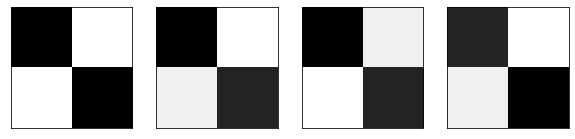

In [7]:
# Examples of faces
faces = [np.array([1,0,0,1]),
         np.array([0.9,0.1,0.2,0.8]),
         np.array([0.9,0.2,0.1,0.8]),
         np.array([0.8,0.1,0.2,0.9]),
         np.array([0.8,0.2,0.1,0.9])]
    
_ = view_samples(faces, 1, 4)

噪音的例子。

以下是随机生成的图片，不对应人脸。

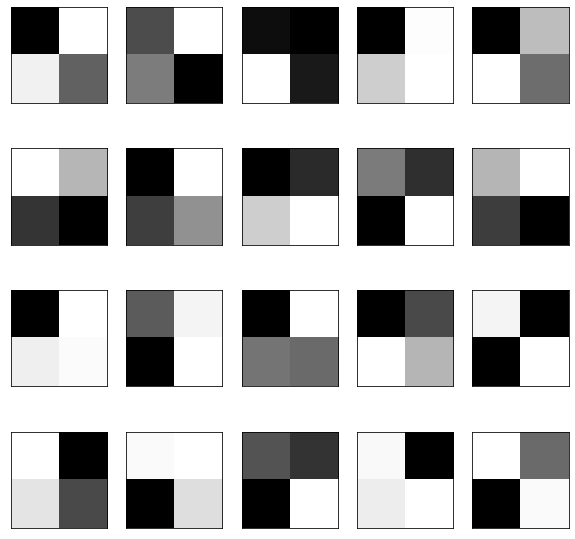

In [8]:
# Examples of noisy images
noise = [np.random.randn(2,2) for i in range(20)]
def generate_random_image():
    return [np.random.random(), np.random.random(), np.random.random(), np.random.random()]

_ = view_samples(noise, 4,5)

下面构建神经网络

In [9]:
# The sigmoid activation function
def sigmoid(x):
    return np.exp(x)/(1.0+np.exp(x))

判别器

![](img/discriminator_math.png)

In [10]:
class Discriminator():
    def __init__(self):
        #self.weights = np.array([0.0 for i in range(4)])
        #self.bias = 0.0
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.bias = np.random.normal()
    
    def forward(self, x):
        # Forward pass
        return sigmoid(np.dot(x, self.weights) + self.bias)
    
    def error_from_image(self, image):
        prediction = self.forward(image)
        # We want the prediction to be 1, so the error is -log(prediction)
        return -np.log(prediction)
    
    def derivatives_from_image(self, image):
        prediction = self.forward(image)
        derivatives_weights = -image * (1-prediction)
        derivative_bias = -(1-prediction)
        return derivatives_weights, derivative_bias
    
    def update_from_image(self, x):
        ders = self.derivatives_from_image(x)
        self.weights -= learning_rate * ders[0]
        self.bias -= learning_rate * ders[1]

    def error_from_noise(self, noise):
        prediction = self.forward(noise)
        # We want the prediction to be 0, so the error is -log(1-prediction)
        return -np.log(1-prediction)
    
    def derivatives_from_noise(self, noise):
        prediction = self.forward(noise)
        derivatives_weights = noise * prediction
        derivative_bias = prediction
        return derivatives_weights, derivative_bias
    
    def update_from_noise(self, noise):
        ders = self.derivatives_from_noise(noise)
        self.weights -= learning_rate * ders[0]
        self.bias -= learning_rate * ders[1]

## The Generator

![](img/generator_math.png)

In [11]:
class Generator():
    def __init__(self):
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.biases = np.array([np.random.normal() for i in range(4)])

    def forward(self, z):
        # Forward pass
        return sigmoid(z * self.weights + self.biases)

    def error(self, z, discriminator):
        x = self.forward(z)
        # We want the prediction to be 0, so the error is -log(1-prediction)
        y = discriminator.forward(x)
        return -np.log(y)

    def derivatives(self, z, discriminator):
        discriminator_weights = discriminator.weights
        discriminator_bias = discriminator.bias
        x = self.forward(z)
        y = discriminator.forward(x)
        factor = -(1-y) * discriminator_weights * x *(1-x)
        derivatives_weights = factor * z
        derivative_bias = factor
        return derivatives_weights, derivative_bias

    def update(self, z, discriminator):
        error_before = self.error(z, discriminator)
        ders = self.derivatives(z, discriminator)
        self.weights -= learning_rate * ders[0]
        self.biases -= learning_rate * ders[1]
        error_after = self.error(z, discriminator)

训练

In [12]:
# Set random seed
np.random.seed(42)

# Hyperparameters
learning_rate = 0.01
epochs = 1000

# The GAN
D = Discriminator()
G = Generator()

# For the error plot
errors_discriminator = []
errors_generator = []

for epoch in range(epochs):
    
    for face in faces:
        
        # Update the discriminator weights from the real face
        D.update_from_image(face)
    
        # Pick a random number to generate a fake face
        z = random.rand()

        # Calculate the discriminator error
        errors_discriminator.append(sum(D.error_from_image(face) + D.error_from_noise(z)))
        
        # Calculate the generator error
        errors_generator.append(G.error(z, D))
        
        # Build a fake face
        noise = G.forward(z)
        
        # Update the discriminator weights from the fake face
        D.update_from_noise(noise)
    
        # Update the generator weights from the fake face
        G.update(z, D)

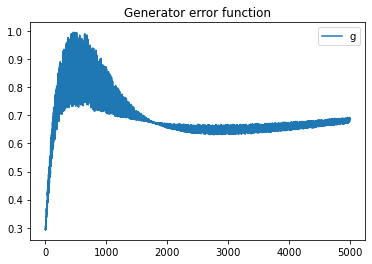

Text(0.5, 1.0, 'Discriminator error function')

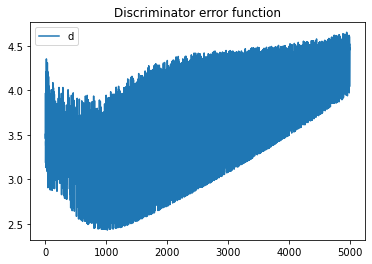

In [13]:
import matplotlib.pyplot as plt
plt.plot(errors_generator)
plt.title("Generator error function")
plt.legend("gen")
plt.show()
plt.plot(errors_discriminator)
plt.legend('disc')
plt.title("Discriminator error function")

生成图像

[0.94688171 0.03401213 0.04080795 0.96308679]
[0.95653992 0.03437852 0.03579494 0.97063836]
[0.95056667 0.03414339 0.03893305 0.96599501]
[0.94228203 0.03386046 0.04309146 0.95941292]


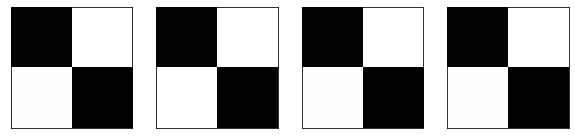

In [14]:
generated_images = []
for i in range(4):
    z = random.random()
    generated_image = G.forward(z)
    generated_images.append(generated_image)
_ = view_samples(generated_images, 1, 4)
for i in generated_images:
    print(i)

看看生成器和判别器的权重和偏差

In [15]:
print("Generator weights", G.weights)
print("Generator biases", G.biases)

Generator weights [ 0.70702123  0.03720449 -0.45703394  0.79375751]
Generator biases [ 2.48490157 -3.36725912 -2.90139211  2.8172726 ]


In [16]:
print("Discriminator weights", D.weights)
print("Discriminator bias", D.bias)

Discriminator weights [ 0.60175083 -0.29127513 -0.40093314  0.37759987]
Discriminator bias -0.8955103005797738


接下来是一些基于现有代码框架的GAN代码示例。

未完待续。。。